In [1]:
# pip install azure-ai-textanalytics mlflow

In [ ]:
# # Asignation de Databricks CE comme serveur de tracking
# mlflow.login()
# mlflow.set_tracking_uri("databricks")
# # Création de l'expérimentation "approche classique"
# mlflow.set_experiment("/Users/cecilemayer@live.com/azure_language_analytics")

In [1]:
import mlflow
# Asignation du serveur de tracking MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
# Création de l'expérimentation "approche classique"
mlflow.set_experiment("approche_classique")

<Experiment: artifact_location='mlflow-artifacts:/374735653194037029', creation_time=1729108772155, experiment_id='374735653194037029', last_update_time=1729108772155, lifecycle_stage='active', name='approche_classique', tags={}>

In [2]:
import os

# This example requires environment variables named "LANGUAGE_KEY" and "LANGUAGE_ENDPOINT"
language_key = "c2a3a85df2864bbd88d18e2006d64bf4"
# os.environ.get('LANGUAGE_KEY')
language_endpoint = "https://aiep7-2.cognitiveservices.azure.com/"
# os.environ.get('LANGUAGE_ENDPOINT')


In [3]:
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

In [4]:
# Authenticate the client using your key and endpoint 
def authenticate_client():
    ta_credential = AzureKeyCredential(language_key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=language_endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

In [5]:
# 2. Fonction pour analyser le sentiment d'un texte
def sentiment_analysis(client, documents):
    sentiments = []
    batch_size = 10  # Azure ne permet pas plus de 10 documents par requête

    for i in range(0, len(documents), batch_size):
        batch = documents[i:i + batch_size]  # Diviser les documents en lots de 10
        response = client.analyze_sentiment(documents=batch)
        for doc in response:
            if not doc.is_error:
                sentiment = 0 if doc.sentiment == "positive" else 1
                sentiments.append(sentiment)
            else:
                sentiments.append(None)  # Pour gérer les erreurs éventuelles
    return sentiments

In [6]:
# 3. Analyser le dataframe
def add_sentiment_column(data, column):
    client = authenticate_client()
    documents = data[column].tolist()  # Extraire les textes à analyser
    sentiments = sentiment_analysis(client, documents)  # Analyser le sentiment
    
    new_column_name = f"azure_sentiment_{column}"  # Concaténer azure_sentiment avec le nom de la colonne
    data[new_column_name] = sentiments  # Ajouter les résultats comme nouvelle colonne
    
    return data

In [9]:
import pandas as pd
data = pd.read_csv("./data/data_preprocessed.csv", index_col=0)

In [10]:
# Ajouter la colonne 'azure_sentiment_preprocessed_text'
data = add_sentiment_column(data, "preprocessed_text")

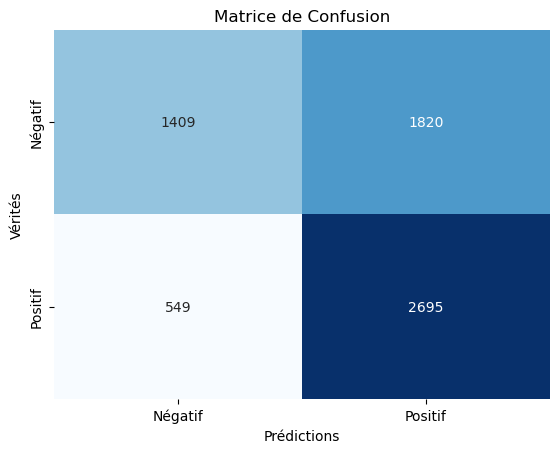

Rapport de Classification:

              precision    recall  f1-score   support

     Négatif       0.72      0.44      0.54      3229
     Positif       0.60      0.83      0.69      3244

    accuracy                           0.63      6473
   macro avg       0.66      0.63      0.62      6473
weighted avg       0.66      0.63      0.62      6473



In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Afficher la matrice de confusion
def plot_confusion_matrix(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_preprocessed_text']  # Prédictions
    cm = confusion_matrix(y_true, y_pred)  # Calculer la matrice de confusion
    
    # Afficher la matrice de confusion avec seaborn pour une meilleure visualisation
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Négatif', 'Positif'], 
                yticklabels=['Négatif', 'Positif'])
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.title('Matrice de Confusion')
    plt.show()

# 2. Afficher le rapport de classification
def print_classification_report(data):
    y_true = data['target']  # Labels réels
    y_pred = data['azure_sentiment_preprocessed_text']  # Prédictions
    report = classification_report(y_true, y_pred, target_names=['Négatif', 'Positif'])
    print("Rapport de Classification:\n")
    print(report)

# Afficher la matrice de confusion
plot_confusion_matrix(data)

# Afficher le rapport de classification
print_classification_report(data)

In [12]:
# Ajouter la colonne 'azure_sentiment_text'
data = add_sentiment_column(data, "text")
data.head()

,target,ids,date,flag,user,text,sentiment_score,cleaned_text,tokenized,preprocessed_text,preprocessed_tokenized,length_text,length_tokenized,length_preprocessed_tokenized,azure_sentiment_preprocessed_text,azure_sentiment_text
364415,1,2048153698,Fri Jun 05 14:44:47 PDT 2009,NO_QUERY,KRagsdill,Bought a book to read on the plane. &quot;Smas...,0,"Bought a book to read on the plane. ""Smashed""....","['Bought', 'a', 'book', 'to', 'read', 'on', 't...",bought book read plane smashed far sound ...,"['bought', 'book', 'read', 'plane', 'smashed',...",141,35,14,1,1
61776,1,1686846342,Sun May 03 06:58:32 PDT 2009,NO_QUERY,kymmskreations,Waiting at the airport with the hubby this mor...,0,Waiting at the airport with the hubby this mor...,"['Waiting', 'at', 'the', 'airport', 'with', 't...",waiting airport hubby morning 1 hour till fli...,"['waiting', 'airport', 'hubby', 'morning', '1'...",82,16,9,1,1
307389,1,2000460643,Mon Jun 01 22:09:58 PDT 2009,NO_QUERY,rachelslott,OH WOW FAIL. My thoughts are with all those of...,0,"OH, WOW FAIL. My thoughts are with all those o...","['OH', ',', 'WOW', 'FAIL', '.', 'My', 'thought...",oh wow fail thought air france flight family,"['oh', 'wow', 'fail', 'thought', 'air', 'franc...",88,19,8,1,1
764377,1,2298848205,Tue Jun 23 12:11:12 PDT 2009,NO_QUERY,lolaspitfire,Off to the airport! Dallas here I come!,0,Off to the airport! Dallas here I come!,"['Off', 'to', 'the', 'airport', '!', 'Dallas',...",airport ! dallas come !,"['airport', '!', 'dallas', 'come', '!']",40,10,5,1,1
337691,1,2014267023,Wed Jun 03 00:58:36 PDT 2009,NO_QUERY,XxBEeMeCkSxX,Broke my iPhone tonight from slipping pedals l...,0,Broke my iPhone tonight from slipping pedals l...,"['Broke', 'my', 'iPhone', 'tonight', 'from', '...",broke iphone tonight slipping pedal landing se...,"['broke', 'iphone', 'tonight', 'slipping', 'pe...",138,29,16,1,1


In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

# Supposons que vous avez un DataFrame `data` avec les colonnes `azure_sentiment_text` et `target`
y_true = data['target']  # Étiquettes réelles
y_pred = data['azure_sentiment_text']  # Prédictions du classifieur

accuracy = accuracy_score(y_true, y_pred)
report = classification_report(y_true, y_pred, output_dict=True)
cm = confusion_matrix(y_true, y_pred)

In [14]:
# Convertir le rapport en DataFrame
report_df = pd.DataFrame(report).transpose()

# Afficher le DataFrame
print(report_df)

              precision    recall  f1-score      support
0              0.787160  0.493651  0.606776  3229.000000
1              0.632419  0.867139  0.731409  3244.000000
accuracy       0.680828  0.680828  0.680828     0.680828
macro avg      0.709790  0.680395  0.669093  6473.000000
weighted avg   0.709610  0.680828  0.669237  6473.000000


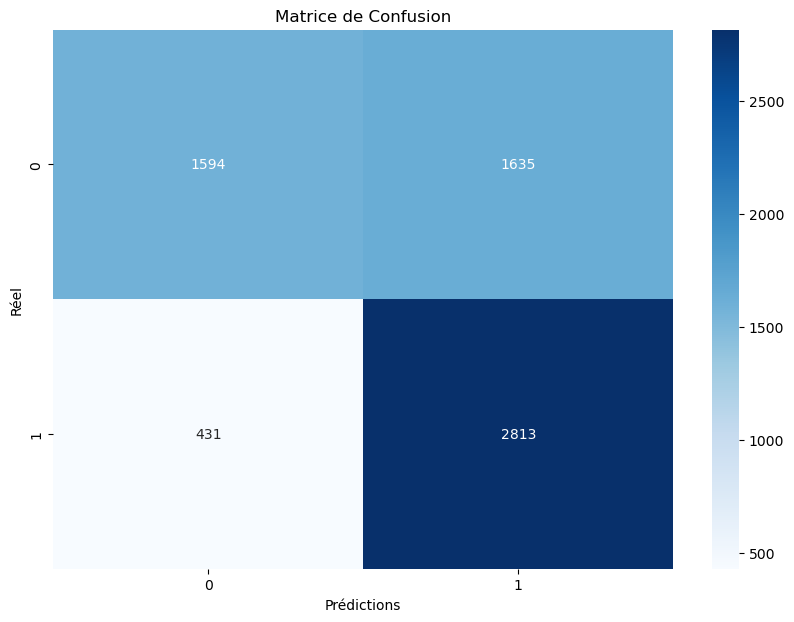

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Afficher la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Réel')

# Sauvegarder la figure
plt.savefig("confusion_matrix.png")
plt.show()  # Ajouter cette ligne pour afficher la figure
plt.close()


A partir de la colonne "text" (non pré-traité): on a arrive à un taux de détection des positifs élevé, mais en contrepartie la classe négative comporte de nombreuses erreurs ce qui résulte en un nombre important de faux positifs. Les faux négatifs sont très limités, ce qui est la tendance voulue: on ne veut pas louper les mauvaises appréciations. Dans ce modèle on a une vision pessimiste de l'appréciation des tweets.<br>
Le modèle depuis le texte prétraité possède les mêmes caractéristiques mais il est moins performant: l'exactitude de prédiction moyenne est légèrement inférieure.

In [16]:
data.to_csv("./data/test_azure.csv", index=True)

In [17]:
with mlflow.start_run(run_name="Azure Text Analytics"):
    # Enregistrer les métriques
    mlflow.log_metric("accuracy", accuracy)
    for label, metrics in report.items():
        if label not in ['accuracy', 'macro avg', 'weighted avg']:  # Ignorer les moyennes
            mlflow.log_metric(f"precision_{label}", metrics['precision'])
            mlflow.log_metric(f"recall_{label}", metrics['recall'])
            mlflow.log_metric(f"f1-score_{label}", metrics['f1-score'])

    # Enregistrer la matrice de confusion
    mlflow.log_artifact("confusion_matrix.png")
    mlflow.log_artifact("./data/test_azure.csv")

2024/11/04 09:38:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run Azure Text Analytics at: http://localhost:5000/#/experiments/374735653194037029/runs/3f5251ac0f76446688fed59189f2ed7b.
2024/11/04 09:38:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/374735653194037029.
